In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.si_ae import SideInformationAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [3]:
config.H_target = 2* 0.3
config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.beta

500

In [4]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func):
        # If it's a partial, use func.func
        name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        X_DEC_IND =1
        val = self.func(last_output[X_DEC_IND], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)

In [5]:
# config.use_si_flag = SiNetChannelIn.WithSideInformation
config.use_si_flag

<SiNetChannelIn.NoSideInformation: 3>

In [6]:
torch.__version__

'1.4.0'

In [8]:
si_autoencoder = SideInformationAutoEncoder(config.use_si_flag)
path = "../src/dsin/data"
pct=0.001
valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_general_val.txt"],pct=pct)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_general_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)

# ll = image_lists.label_from_func(lambda x: x)

tfms = None #get_transforms(do_flip=True, max_rotate=0.0)
batchsize = 1
data = (image_lists
        .label_from_func(lambda x: x)
        .transform(tfms, size=(336, 1224), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))
learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(config.use_si_flag),
                     metrics=[AverageMetric(Distortions._calc_dist)])



In [10]:
len(learn.data.valid_ds)

1

In [8]:
learn.load('full-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1576 items)
x: SideinformationImageImageList
ImageSiTuple [tensor([[[0.0866, 0.0857, 0.0909,  ..., 1.0000, 1.0000, 1.0000],
         [0.1137, 0.1107, 0.1078,  ..., 1.0000, 1.0000, 1.0000],
         [0.1178, 0.1198, 0.1188,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.1303, 0.1213, 0.1057,  ..., 0.0451, 0.0490, 0.0491],
         [0.1244, 0.1155, 0.1029,  ..., 0.0460, 0.0500, 0.0471],
         [0.1216, 0.1105, 0.0990,  ..., 0.0469, 0.0509, 0.0501]],

        [[0.0950, 0.0900, 0.0996,  ..., 1.0000, 1.0000, 1.0000],
         [0.1009, 0.1069, 0.1208,  ..., 1.0000, 1.0000, 1.0000],
         [0.1108, 0.1217, 0.1274,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.1470, 0.1549, 0.1588,  ..., 0.0560, 0.0511, 0.0520],
         [0.1549, 0.1599, 0.1637,  ..., 0.0607, 0.0628, 0.0599],
         [0.1569, 0.1608, 0.1617,  ..., 0.0656, 0.0726, 0.0688]],

        [[0.1020, 0.1146, 0.1118,  ..., 1.0000, 1.0000, 1.0000],
         [0.1077

In [14]:
learn.model.true_tuple_loss_false_just_out = True

learn.lr_find()

epoch,train_loss,valid_loss,_calc_dist,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


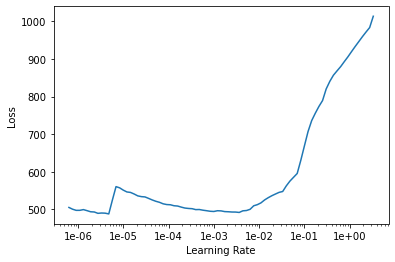

In [15]:
learn.recorder.plot()


In [10]:
learn.model.true_tuple_loss_false_just_out = True

learn.fit(1, lr=0.0005)
learn.save('mssim -lr0p0005 -full-stage-1')

epoch,train_loss,valid_loss,_calc_dist,time
0,464.428925,484.319458,3882.436035,09:05


In [21]:
learn.model.true_tuple_loss_false_just_out = True

learn.fit(1, lr=0.004)

epoch,train_loss,valid_loss,_calc_dist,time
0,457.228577,448.484192,0.449909,08:36


In [20]:
learn.load('mssim -lr0p0005 -full-stage-1')
learn.model.true_tuple_loss_false_just_out = True

learn.fit(1, lr=0.0005,wd=0.0001)
learn.save('mssim -lr0p00005 -full-stage-2')

epoch,train_loss,valid_loss,_calc_dist,time
0,446.723022,439.162689,4013.479492,09:06


In [ ]:
learn.fit(1, lr=0.0005,wd=0.0001)

In [ ]:
learn.load('mssim -lr0p0005 -full-stage-1')

learn.model.true_tuple_loss_false_just_out = False

learn.show_results(figsize=(30,30))

In [ ]:

learn.model.true_tuple_loss_false_just_out = True

for i in range(4):
    lr = 0.0001
    wd = 0.0001
    learn.fit(1, lr=lr,wd=wd)
    learn.save(f'mssim -full-stage-{i} -lr{lr} -wd{wd}')

epoch,train_loss,valid_loss,_calc_dist,time


In [11]:
# # my_learner.fit_one_cycle(10)
# # my_learner.lr_find()
# # my_learner.save('stage-1')
# # my_learner.recorder.plot()
# # my_learner.load('stage-1')
# # my_learner.save("trained_model-stage1", return_path=True)
# # my_learner.export("trained_model_ex_stage1.pkl")